# Make figures and examples for dependence metric calculation

The equation for how signal is dependent on changes in S0 and T2*:
$$S(t, TE_k) = \bar{S}(TE_k) * (1 + \frac{{\Delta}{S_0}(t)}{\bar{S}_0} - {\Delta}{R_2^*}(t)*TE_k)$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import add_constant
from scipy import stats, signal

from nilearn import masking
import pandas as pd

from nistats import hemodynamic_models

import seaborn as sns
sns.set_style('whitegrid')

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
def pred_signal_monoexponential(echo_times, s0, t2s):
    """
    Predict multi-echo signal from S0, T2*, and echo
    times (in ms) according to monoexponential decay model.
    
    This is meant to be a sort of inverse to the code used
    in tedana.decay.fit_decay
    """
    if not isinstance(t2s, np.ndarray):
        t2s = np.array(t2s)

    if not isinstance(s0, np.ndarray):
        s0 = np.array(s0)

    neg_tes = (-1 * echo_times)[None, :]
    r2s = (1 / t2s)[:, None]
    intercept = np.log(s0)[:, None]
    log_data = np.dot(r2s, neg_tes) + intercept
    # Removed -1 from outside exp because it messes up dt_sig2
    data = np.exp(log_data).T
    return data


def pred_loglinear(data, echo_times):
    log_data = np.log(np.abs(data) + 1)
    

def compute_metrics(data, B, tes):
    tes = tes[:, None]
    data = data[None, ...]
    B = B[:, None]
    n_echos = len(tes)
    alpha = (np.abs(B)**2).sum(axis=0)
    mu = np.mean(data, axis=-1)
    X1 = mu.T  # Model 1
    X2 = np.tile(tes, (1, 1)) * mu.T  # Model 2

    # S0 Model
    # (S,) model coefficient map
    coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
    pred_S0 = X1 * np.tile(coeffs_S0, (n_echos, 1))
    SSE_S0 = (B - pred_S0)**2
    SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
    F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)

    # R2 Model
    coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
    pred_R2 = X2 * np.tile(coeffs_R2, (n_echos, 1))
    SSE_R2 = (B - pred_R2)**2
    SSE_R2 = SSE_R2.sum(axis=0)
    F_R2 = (alpha - SSE_R2) * (n_echos - 1) / (SSE_R2)
    
    return F_S0, F_R2, pred_S0, pred_R2


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


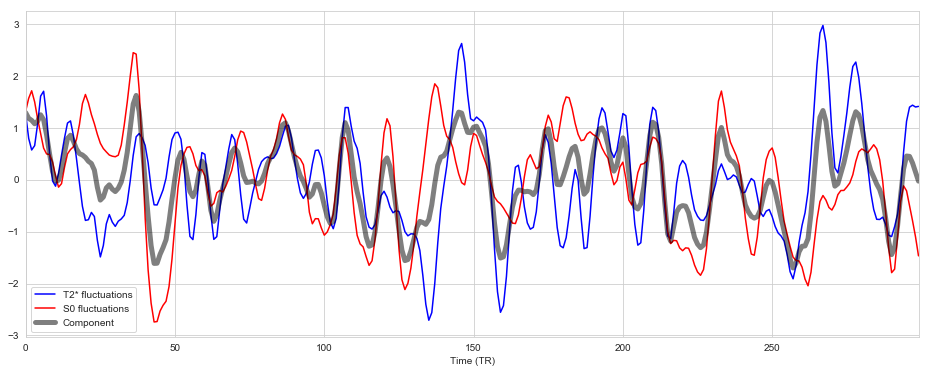

In [3]:
# Simulate data
# For a nice, smooth curve
echo_times = np.arange(0, 151, 1)

# logan's TEs
echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

# dan's TEs
#echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

# We'll convolve with HRF just for smoothness
hrf = hemodynamic_models.spm_hrf(1, oversampling=1)

n_trs = 300

frac = 0.05  # 5% PSC
mean_t2s = 30
t2s_std = mean_t2s * frac
mean_s0 = 16000
s0_std = mean_s0 * frac

# simulate the T2*/S0 time series 
t2s_ts = np.random.normal(loc=mean_t2s, scale=t2s_std, size=(n_trs+20,))
t2s_ts = signal.convolve(t2s_ts, hrf)[20:n_trs+20]
t2s_ts *= t2s_std / np.std(t2s_ts)
t2s_ts += mean_t2s - np.mean(t2s_ts)

s0_ts = np.random.normal(loc=mean_s0, scale=s0_std, size=(n_trs+20,))
s0_ts = signal.convolve(s0_ts, hrf)[20:n_trs+20]
s0_ts *= s0_std / np.std(s0_ts)
s0_ts += mean_s0 - np.mean(s0_ts)

# Constant T2*/S0 time series
mean_s0_ts = np.ones(n_trs) * mean_s0
mean_t2s_ts = np.ones(n_trs) * mean_t2s

# Simulate signal 
t2s_sig = pred_signal_monoexponential(echo_times, mean_s0_ts, t2s_ts)
s0_sig = pred_signal_monoexponential(echo_times, s0_ts, mean_t2s_ts)
both_sig = pred_signal_monoexponential(echo_times, s0_ts, t2s_ts)

# Normalize to get component time series
t2s_comp = stats.zscore(t2s_ts)
s0_comp = stats.zscore(s0_ts)

# Combine at different ratios
p = 0.5
comp = (p * t2s_comp) + ((1 - p) * s0_comp)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t2s_comp, label='T2* fluctuations', color='blue')
ax.plot(s0_comp, label='S0 fluctuations', color='red')
ax.plot(comp, label='Component', color='black', alpha=0.5, linewidth=5)
ax.set_xlim(0, n_trs-1)
ax.set_xlabel('Time (TR)')
leg = ax.legend()
fig.show()

rho = 85.69903468385041
kappa = 49.86273920976756
Max val at 34.32ms


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


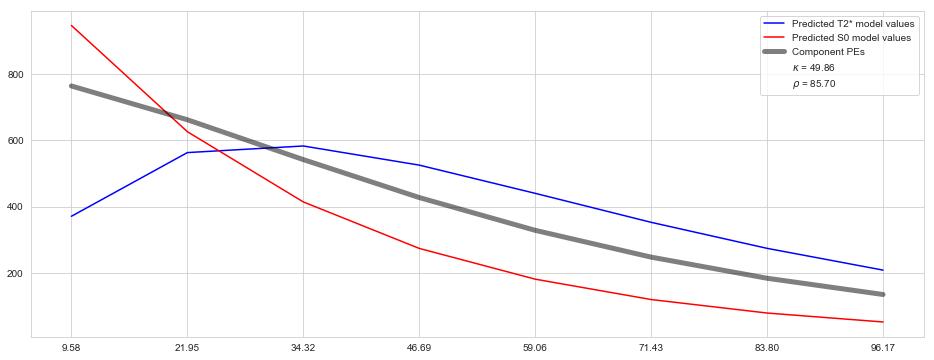

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))

comp_X = add_constant(comp, prepend=False)
pes, b, c, d = np.linalg.lstsq(comp_X, both_sig.T, rcond=None)
pes = pes[0, :]

F_S0, F_R2, pred_S0, pred_R2 = other_thing(both_sig, pes, echo_times)
print('rho = {}'.format(F_S0[0]))
print('kappa = {}'.format(F_R2[0]))
ax.plot(echo_times, pred_R2, linestyle='-', label='Predicted T2* model values', c='blue')
ax.plot(echo_times, pred_S0, linestyle='-', label='Predicted S0 model values', c='red')
ax.plot(echo_times, pes, label='Component PEs', alpha=0.5, linewidth=5, c='black')
ax.plot(echo_times, pred_R2, label=r'$\kappa$ = {:.02f}'.format(F_R2[0]), alpha=0)
ax.plot(echo_times, pred_S0, label=r'$\rho$ = {:.02f}'.format(F_S0[0]), alpha=0)
print('Max val at {}ms'.format(echo_times[np.where(pred_R2 == np.max(pred_R2))[0][0]]))
leg = ax.legend()
ax.set_xticks(echo_times)
fig.show()